# KNN_SVM_프로모션_효율예측분석

In [3]:
# 필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

## 데이터 불러오기 및 데이터 확인

In [2]:
mem = pd.read_csv("./data/member.csv")
tran = pd.read_csv("./data/transaction.csv")

## 컬럼 설명
- 쇼핑몰 고객 데이터, 프로모션 쿠폰을 발행하고 사용 여부 데이터 수집
- mem : 고객id, 최근 방문일, 사는 지역, 추천여부, 주요접속체널, 쿠폰사용여부(target)
- tran : 고객id, 구매수량, 총 구매금액
---
- 전통적 마케팅 분석 방법 RFM 기법을 활용해 고객 데이터에서 파생변수 생성 후 분석
- R: Recency: 현재일 - 최근 구매일
- F: Frequency: 구매빈도
- M: Monetary: 구매 금액
- 종속변수: conversion => 고객이 프로모션에 반응 했는가? 1 =yes, 0 = no

In [4]:
mem.head(2)

,id,recency,zip_code,is_referral,channel,conversion
0,906145,10,Surburban,0,Phone,0
1,184478,6,Rural,1,Web,0


In [5]:
tran.head()

,id,num_item,total_amount
0,906145,5,34000
1,906145,1,27000
2,906145,4,33000
3,184478,4,29000
4,394235,4,33000


## 결측값 탐지 및 처리


In [8]:
mem.isna().sum()

id             0
recency        0
zip_code       0
is_referral    0
channel        0
conversion     0
dtype: int64

In [7]:
tran.isna().sum()

id              0
num_item        0
total_amount    0
dtype: int64

In [20]:
# mem 데이터 정보 확인
mem.info()
print()
print('='*100)
mem.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           64000 non-null  int64 
 1   recency      64000 non-null  int64 
 2   zip_code     64000 non-null  object
 3   is_referral  64000 non-null  int64 
 4   channel      64000 non-null  object
 5   conversion   64000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 2.9+ MB



,id,recency,zip_code,is_referral,channel,conversion
count,64000.000000,64000.000000,64000,64000.000000,64000,64000.000000
unique,NaN,NaN,3,NaN,3,NaN
top,NaN,NaN,Surburban,NaN,Web,NaN
freq,NaN,NaN,28776,NaN,28217,NaN
mean,550694.137797,5.763734,NaN,0.502250,NaN,0.146781
std,259105.689773,3.507592,NaN,0.499999,NaN,0.353890
min,100001.000000,1.000000,NaN,0.000000,NaN,0.000000
25%,326772.000000,2.000000,NaN,0.000000,NaN,0.000000
50%,551300.000000,6.000000,NaN,1.000000,NaN,0.000000
75%,774914.500000,9.000000,NaN,1.000000,NaN,0.000000


In [15]:
# tran 데이터 정보 확인
tran.info()
print()
print('='*100)
tran.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196836 entries, 0 to 196835
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   id            196836 non-null  int64
 1   num_item      196836 non-null  int64
 2   total_amount  196836 non-null  int64
dtypes: int64(3)
memory usage: 4.5 MB



,id,num_item,total_amount
count,196836.000000,196836.000000,196836.000000
mean,550557.552932,3.078365,21837.102969
std,259254.795613,1.478408,8218.005565
min,100001.000000,1.000000,8000.000000
25%,326719.000000,2.000000,15000.000000
50%,550918.000000,3.000000,22000.000000
75%,774916.000000,4.000000,29000.000000
max,999997.000000,6.000000,38000.000000


 ## EDA(탐색적 데이터 분석)

In [16]:
mem.columns

Index(['id', 'recency', 'zip_code', 'is_referral', 'channel', 'conversion'], dtype='object')

In [18]:
# id가 독립적인 경우만 확인
mem['id'].nunique()

64000

In [25]:
for col in mem.columns:
#     print(col)
    print('='* 30, col, '='*30)
    print(f'{col}의 독립적인 값의 수 : {mem[col].nunique()}')
    print()
    
    print(f"{col}의 value_counts")
    print(mem[col].value_counts())
    print()
    

============================== id ==============================
id의 독립적인 값의 수 : 64000

id의 value_counts
id
899664    1
302540    1
481784    1
709285    1
353695    1
         ..
130152    1
940352    1
612635    1
872298    1
103308    1
Name: count, Length: 64000, dtype: int64

============================== recency ==============================
recency의 독립적인 값의 수 : 12

recency의 value_counts
recency
1     8952
10    7565
2     7537
9     6441
3     5904
4     5077
6     4605
5     4510
7     4078
11    3504
8     3495
12    2332
Name: count, dtype: int64

============================== zip_code ==============================
zip_code의 독립적인 값의 수 : 3

zip_code의 value_counts
zip_code
Surburban    28776
Urban        25661
Rural         9563
Name: count, dtype: int64

============================== is_referral ==============================
is_referral의 독립적인 값의 수 : 2

is_referral의 value_counts
is_referral
1    32144
0    31856
Name: count, dtype: int64

============================== ch

### tran 테이블에서의 평균 금액, 빈도 확인

#### 고객 행동 패턴의 일반화 : 평균 품목수, 평균 결제 금액
- 고객(id) 단위의 고정된 피처(feature) 생성
    - 한 고객(id)에 거래가 여러 건 있을 수 있어 머신러닝 모델에 넣기에 어려움 존재
    - 하나의 고객 단위 요약 테이블로 생성


In [27]:
tran.describe()

,id,num_item,total_amount
count,196836.000000,196836.000000,196836.000000
mean,550557.552932,3.078365,21837.102969
std,259254.795613,1.478408,8218.005565
min,100001.000000,1.000000,8000.000000
25%,326719.000000,2.000000,15000.000000
50%,550918.000000,3.000000,22000.000000
75%,774916.000000,4.000000,29000.000000
max,999997.000000,6.000000,38000.000000


In [34]:
mean_item_amount = tran.groupby('id')[['num_item', 'total_amount']].mean()
mean_item_amount = mean_item_amount.reset_index()

In [35]:
mean_item_amount.columns = ['id', 'mean_num_item', 'mean_total_amount']
mean_item_amount

,id,mean_num_item,mean_total_amount
0,100001,3.500000,26000.000000
1,100008,5.000000,26000.000000
2,100032,2.666667,20666.666667
3,100036,3.000000,25800.000000
4,100070,3.250000,21250.000000
...,...,...,...
63995,999932,5.000000,32000.000000
63996,999981,2.000000,22750.000000
63997,999990,3.000000,28000.000000
63998,999995,2.000000,27000.000000


### RFM 모델링
- RFM 모델링
    - R: Recency: 현재일 - 최근 구매일
    - F: Frequency: 구매빈도
    - M: Monetary: 구매 금액

In [37]:
# 얼마나 자주 구매를 하는지 확인
freq = tran.groupby('id')['id'].count()
freq

id
100001    2
100008    1
100032    3
100036    5
100070    4
         ..
999932    1
999981    4
999990    3
999995    1
999997    1
Name: id, Length: 64000, dtype: int64

In [38]:
# 인데스를 id 기준으로 변환
mean_item_amount = mean_item_amount.set_index('id')

# 얼마나 자주 구매했는지 frequency 컬럼 추가
# 기존의 id라는 컬럼명을 frequency라는 컬럼명으로 변환
mean_item_amount = mean_item_amount.join(freq)
mean_item_amount = mean_item_amount.rename(columns={'id':'frequency'})
mean_item_amount


,mean_num_item,mean_total_amount,frequency
id,,,
100001,3.500000,26000.000000,2
100008,5.000000,26000.000000,1
100032,2.666667,20666.666667,3
100036,3.000000,25800.000000,5
100070,3.250000,21250.000000,4
...,...,...,...
999932,5.000000,32000.000000,1
999981,2.000000,22750.000000,4
999990,3.000000,28000.000000,3


In [39]:
# 총 구매 개수, 총 금액 추가
total_num_amount = tran.groupby('id')[['num_item', 'total_amount']].sum()
total_num_amount

,num_item,total_amount
id,,
100001,7,52000
100008,5,26000
100032,8,62000
100036,15,129000
100070,13,85000
...,...,...
999932,5,32000
999981,8,91000
999990,9,84000


In [40]:
# 기존의 mean_item_amount 테이블에 총 구매개수와 금액 추가
mean_item_total = mean_item_amount.join(total_num_amount)
mean_item_total = mean_item_total.reset_index()
mean_item_total

,id,mean_num_item,mean_total_amount,frequency,num_item,total_amount
0,100001,3.500000,26000.000000,2,7,52000
1,100008,5.000000,26000.000000,1,5,26000
2,100032,2.666667,20666.666667,3,8,62000
3,100036,3.000000,25800.000000,5,15,129000
4,100070,3.250000,21250.000000,4,13,85000
...,...,...,...,...,...,...
63995,999932,5.000000,32000.000000,1,5,32000
63996,999981,2.000000,22750.000000,4,8,91000
63997,999990,3.000000,28000.000000,3,9,84000
63998,999995,2.000000,27000.000000,1,2,27000


### mem(회원정보) 테이블과 mean_item_total(구매 개수, 금액 등을 그룹 연산) 태아블 합치기

In [42]:
data = pd.merge(mem, mean_item_total, how='left', on='id')
data

,id,recency,zip_code,is_referral,channel,conversion,mean_num_item,mean_total_amount,frequency,num_item,total_amount
0,906145,10,Surburban,0,Phone,0,3.333333,31333.333333,3,10,94000
1,184478,6,Rural,1,Web,0,4.000000,29000.000000,1,4,29000
2,394235,7,Surburban,1,Web,0,4.000000,20500.000000,2,8,41000
3,130152,9,Rural,1,Web,0,1.750000,20750.000000,4,7,83000
4,940352,2,Urban,0,Web,0,3.000000,31000.000000,1,3,31000
...,...,...,...,...,...,...,...,...,...,...,...
63995,838295,10,Urban,0,Web,0,3.500000,26000.000000,4,14,104000
63996,547316,5,Urban,1,Phone,0,1.800000,17800.000000,5,9,89000
63997,131575,6,Urban,1,Phone,0,4.000000,30500.000000,2,8,61000
63998,603659,1,Surburban,1,Multichannel,0,3.200000,21600.000000,5,16,108000


In [47]:
data.columns

Index(['id', 'recency', 'zip_code', 'is_referral', 'channel', 'conversion',
       'mean_num_item', 'mean_total_amount', 'frequency', 'num_item',
       'total_amount'],
      dtype='object')

============================== id ==============================
id 히스토그램


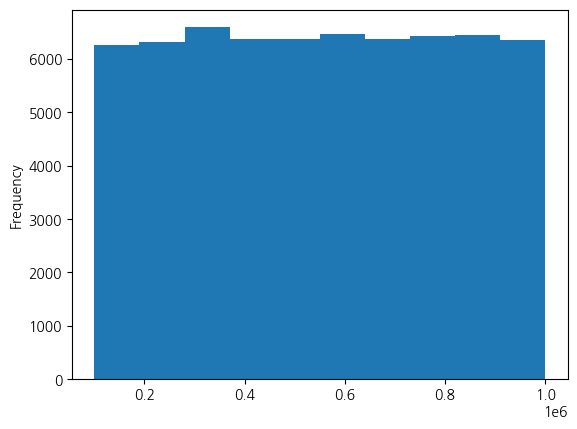




============================== recency ==============================
recency 히스토그램


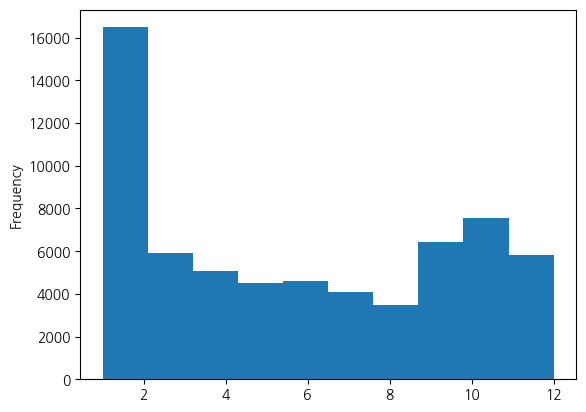




============================== is_referral ==============================
is_referral 히스토그램


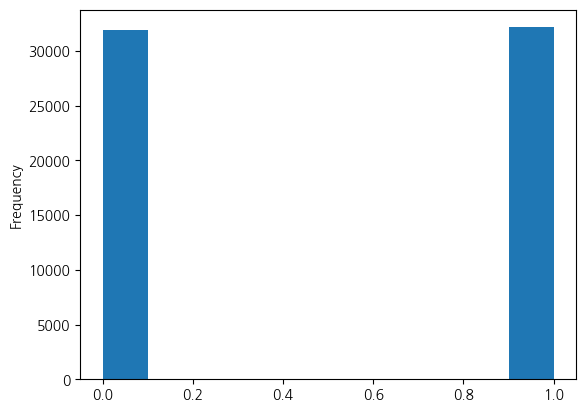




============================== conversion ==============================
conversion 히스토그램


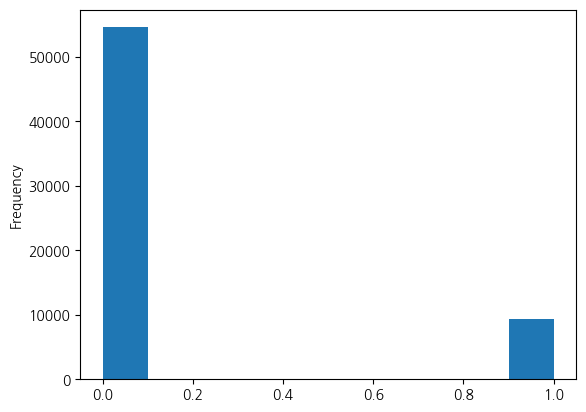




============================== mean_num_item ==============================
mean_num_item 히스토그램


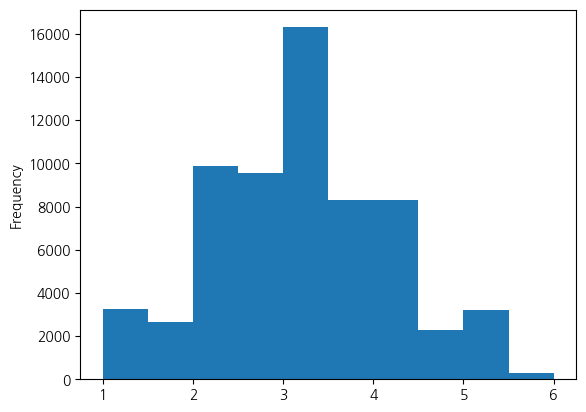




============================== mean_total_amount ==============================
mean_total_amount 히스토그램


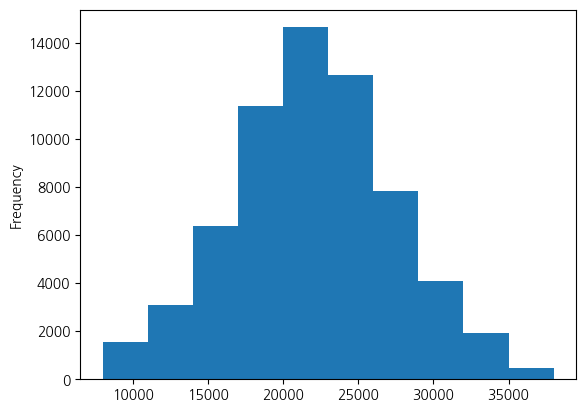




============================== frequency ==============================
frequency 히스토그램


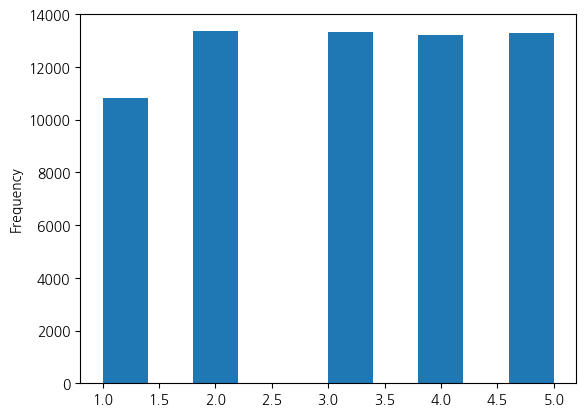




============================== num_item ==============================
num_item 히스토그램


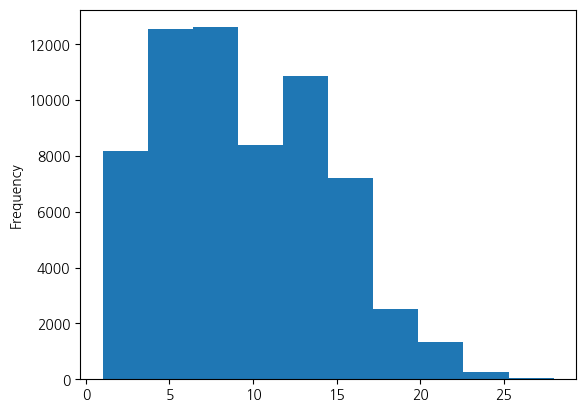




============================== total_amount ==============================
total_amount 히스토그램


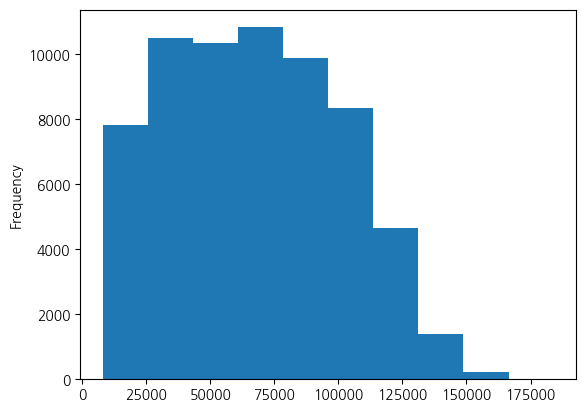

In [51]:
import matplotlib.pyplot as plt

data_num = data.select_dtypes(exclude='object')

# 각 컬럼의 히스토그램 확인
for col in data_num:
#     print(col)
    print('='* 30, col, '='*30)
    print(f'{col} 히스토그램')
    
    data[col].plot(kind='hist')
    plt.show()
    print('\n\n')

### 각 컬럼별 전환율 확인

In [52]:
data.columns

Index(['id', 'recency', 'zip_code', 'is_referral', 'channel', 'conversion',
       'mean_num_item', 'mean_total_amount', 'frequency', 'num_item',
       'total_amount'],
      dtype='object')

In [54]:
# 각 컬럼별 전환(conversion)율 확인
# 전환 여부를 제외한 컬럼 이름 할당
col_names = ['id', 'recency', 'zip_code', 'is_referral', 'channel','mean_num_item', 'mean_total_amount', 
             'frequency', 'num_item','total_amount']

# 각 컬럼별 전환율을 확인하고 유의미한 경우 확인
for col in col_names:
#     print(col)
    print('='* 30, col, '='*30)
    print(data.groupby(col)['conversion'].mean().sort_values(ascending=False))
    print()

============================== id ==============================
id
525469    1.0
506857    1.0
481242    1.0
491300    1.0
226128    1.0
         ... 
999932    0.0
999981    0.0
999990    0.0
999995    0.0
999997    0.0
Name: conversion, Length: 64000, dtype: float64

============================== recency ==============================
recency
1     0.193029
2     0.177790
3     0.166328
4     0.148907
5     0.142350
6     0.140717
7     0.133889
8     0.127897
12    0.126930
11    0.120719
9     0.113957
10    0.112624
Name: conversion, dtype: float64

============================== zip_code ==============================
zip_code
Rural        0.188121
Surburban    0.139943
Urban        0.139044
Name: conversion, dtype: float64

============================== is_referral ==============================
is_referral
0    0.173060
1    0.120738
Name: conversion, dtype: float64

============================== channel ==============================
channel
Multichannel    0.171734
Web   

## 거리 기반 알고리즘 사용시 독립변수들 간의 단위를 꼭 맞춰야 함

### 스케일링
- **MinMaxScaler**
    - 모든 값을 0~1 구간으로 선형 변환(분포 모양 유지)하는 스케이링
    - 값이 서로 다른 범위에 존재(분포 형태는 유지하고 싶은 경우)하는 경우 사용
    - 추천 모델 : KNN, K-Means, DBSCAN, 인공신경망 등
    
- **StandardScaler**
    - 평균 0, 표준편차 1로 변환하여 정규 분포 형태로 변환하는 스케일링
    - 대부분 선형 모델에 기본으로 적용
    - 추천 모델 : SVM, 로지스틱 회귀, 선형/릿지/라쏘 회귀, 인공신경망 등

- **RobustScaler**
    - 중앙값 0, IQR을 1로 변환하여 이상치 영향을 최소화하려는 스케일링
    - 이상치가 많아 평균, 표준편차 기반 스케일링이 필요한 경우 사용
    - 추천 모델 : KNN, SVM, 로지스틱 회귀, 선형/릿지/라쏘 회귀, 인공신경망 등

### 머신러닝 모델별 스케일러
- 인공신경망(ANN) : MinMax or Standard, 이상치가 많은 경우는 Robust
- 클러스터링(DBSCAN, KMeans) : MinMax or Standard, 이상치가 많은 경우는 Robust
- 선형 계열 모델 : 대부분 Standard, 이상치 많은 경우는 Robust
- 트리 계열 모델 : 스케일링 불필요


## 스케일링 시점 : train/test로 나눈 후에 실시
### 카테고리 변수는 one-hot encoding 진행

In [57]:
# 원핫 인코딩 필요한 컬럼 확인
data.describe(include='all')

,id,recency,zip_code,is_referral,channel,conversion,mean_num_item,mean_total_amount,frequency,num_item,total_amount
count,64000.000000,64000.000000,64000,64000.000000,64000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
unique,NaN,NaN,3,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Surburban,NaN,Web,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,28776,NaN,28217,NaN,NaN,NaN,NaN,NaN,NaN
mean,550694.137797,5.763734,NaN,0.502250,NaN,0.146781,3.068359,21789.785937,3.075563,9.467703,67161.375000
std,259105.689773,3.507592,NaN,0.499999,NaN,0.353890,0.971138,5400.355825,1.384222,5.037690,33653.059354
min,100001.000000,1.000000,NaN,0.000000,NaN,0.000000,1.000000,8000.000000,1.000000,1.000000,8000.000000
25%,326772.000000,2.000000,NaN,0.000000,NaN,0.000000,2.500000,18250.000000,2.000000,5.000000,39000.000000
50%,551300.000000,6.000000,NaN,1.000000,NaN,0.000000,3.000000,21800.000000,3.000000,9.000000,66000.000000
75%,774914.500000,9.000000,NaN,1.000000,NaN,0.000000,3.750000,25333.333333,4.000000,13.000000,93000.000000


In [58]:
# 원핫인코딩을 통해 데이터 변환
data = pd.get_dummies(data, columns=['zip_code', 'channel'], drop_first=True)
data

,id,recency,is_referral,conversion,mean_num_item,mean_total_amount,frequency,num_item,total_amount,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
0,906145,10,0,0,3.333333,31333.333333,3,10,94000,True,False,True,False
1,184478,6,1,0,4.000000,29000.000000,1,4,29000,False,False,False,True
2,394235,7,1,0,4.000000,20500.000000,2,8,41000,True,False,False,True
3,130152,9,1,0,1.750000,20750.000000,4,7,83000,False,False,False,True
4,940352,2,0,0,3.000000,31000.000000,1,3,31000,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63995,838295,10,0,0,3.500000,26000.000000,4,14,104000,False,True,False,True
63996,547316,5,1,0,1.800000,17800.000000,5,9,89000,False,True,True,False
63997,131575,6,1,0,4.000000,30500.000000,2,8,61000,False,True,True,False
63998,603659,1,1,0,3.200000,21600.000000,5,16,108000,True,False,False,False


### 홀드아웃

In [59]:
X = data.drop(['id', 'conversion'], axis=1)
y = data['conversion']

In [61]:
X.head()

,recency,is_referral,mean_num_item,mean_total_amount,frequency,num_item,total_amount,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
0,10,0,3.333333,31333.333333,3,10,94000,True,False,True,False
1,6,1,4.000000,29000.000000,1,4,29000,False,False,False,True
2,7,1,4.000000,20500.000000,2,8,41000,True,False,False,True
3,9,1,1.750000,20750.000000,4,7,83000,False,False,False,True
4,2,0,3.000000,31000.000000,1,3,31000,False,True,False,True


In [62]:
y.value_counts()

conversion
0    54606
1     9394
Name: count, dtype: int64

In [63]:
from sklearn.model_selection import train_test_split

In [64]:
# train, valid, test로 나눔
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, stratify=y_valid, random_state=42)

## Scaling : 데이터 단위를 맞추기 위함

In [65]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

In [70]:
# MinMaxScaler
mms = MinMaxScaler()
mms.fit(X_train)
mms_X_train = mms.transform(X_train)
mms_X_valid = mms.transform(X_valid)
mms_X_test= mms.transform(X_test)


In [71]:
# MinMaxScaler로 변환된 X 확인
mms_X_train = pd.DataFrame(mms_X_train, columns=X_train.columns)
mms_X_valid = pd.DataFrame(mms_X_valid, columns=X_train.columns)
mms_X_test = pd.DataFrame(mms_X_test, columns=X_train.columns)


In [72]:
X_test.head()

,recency,is_referral,mean_num_item,mean_total_amount,frequency,num_item,total_amount,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
15576,12,1,5.000000,23000.0,1,5,23000,True,False,True,False
24159,4,1,2.333333,21000.0,3,7,63000,True,False,True,False
11135,2,1,2.500000,30500.0,2,5,61000,False,True,True,False
46485,5,0,2.250000,22000.0,4,9,88000,True,False,True,False
27143,6,1,2.500000,16250.0,4,10,65000,False,False,True,False


In [73]:
mms_X_test.head()

,recency,is_referral,mean_num_item,mean_total_amount,frequency,num_item,total_amount,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
0,1.000000,1.0,0.800000,0.500000,0.00,0.148148,0.085227,1.0,0.0,1.0,0.0
1,0.272727,1.0,0.266667,0.433333,0.50,0.222222,0.312500,1.0,0.0,1.0,0.0
2,0.090909,1.0,0.300000,0.750000,0.25,0.148148,0.301136,0.0,1.0,1.0,0.0
3,0.363636,0.0,0.250000,0.466667,0.75,0.296296,0.454545,1.0,0.0,1.0,0.0
4,0.454545,1.0,0.300000,0.275000,0.75,0.333333,0.323864,0.0,0.0,1.0,0.0


## KNN(K-Nearest Neighbor) 모델 적용

In [74]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [75]:
knn = KNeighborsClassifier(n_jobs=8)
knn.fit(mms_X_train, y_train)
valid_pred = knn.predict(mms_X_valid)

print(classification_report(y_valid, valid_pred))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91     10921
           1       0.39      0.14      0.21      1879

    accuracy                           0.84     12800
   macro avg       0.63      0.55      0.56     12800
weighted avg       0.80      0.84      0.81     12800



## KNN의 하이퍼파라미터 튜닝
- n_neighbors = ?(k값)
- 전체 샘플 수 <= 10000 : 홀수 값(3,5,7,..) 사용 (짝수일 때 발생 가능한 동점(tie) 문제 방지)
- 전체 샘플 수 > 10000 : 데이터 크기에 비례하는 값 사용 (자동으로 적절한 이웃 수를 결정해 모델 안정성 향상)
    - $\sqrt{N}$
    - $\log_2 N$
    

In [76]:
# 전체 샘플 수 확인
len(mms_X_train)

38400

In [79]:
# 전체 샘플 수가 10000개 초과임을 확인
# 루트를 활용한 최적의 k 계산
n = len(mms_X_train)
print(n)

k = int(np.sqrt(n))
print(k)

38400
195


In [80]:
# log2(n)을 활용한 최적의 k 계산
n = len(mms_X_train)
print(n)

k_log2 = int(np.log2(n))
print(k_log2)

38400
15


In [81]:
# 루트를 활용한 최적의 k인 195 활용 KNN 모델 통한 예측 확인
knn = KNeighborsClassifier(n_neighbors=195, n_jobs=8)
knn.fit(mms_X_train, y_train)
valid_pred = knn.predict(mms_X_valid)
print(classification_report(y_valid, valid_pred))


              precision    recall  f1-score   support

           0       0.85      1.00      0.92     10921
           1       0.00      0.00      0.00      1879

    accuracy                           0.85     12800
   macro avg       0.43      0.50      0.46     12800
weighted avg       0.73      0.85      0.79     12800



C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [82]:
# log2(n)을 활용한 최적의 k인 15 활용 KNN 모델 통한 예측 확인
knn = KNeighborsClassifier(n_neighbors=15, n_jobs=8)
knn.fit(mms_X_train, y_train)
valid_pred = knn.predict(mms_X_valid)
print(classification_report(y_valid, valid_pred))


              precision    recall  f1-score   support

           0       0.86      0.99      0.92     10921
           1       0.59      0.07      0.13      1879

    accuracy                           0.86     12800
   macro avg       0.73      0.53      0.52     12800
weighted avg       0.82      0.86      0.81     12800



## SMOTENC : 데이터 증폭을 통한 성능 개선
- SMOTE의 변형으로 범주형과 연속형 feature를 모두 다룰 수 있음
- 연속형 피처 : 유클리드 거리를 기준으로 이웃을 고름
- 범주형 피처 : 동일여부 여부(just match)를 기준으로 이웃을 고름
- 소수 클래스 샘플들을 인접 샘플들과 보간하여 새로운 합성 샘플로 생성

In [83]:
mms_X_train.columns

Index(['recency', 'is_referral', 'mean_num_item', 'mean_total_amount',
       'frequency', 'num_item', 'total_amount', 'zip_code_Surburban',
       'zip_code_Urban', 'channel_Phone', 'channel_Web'],
      dtype='object')

In [84]:
from imblearn.over_sampling import SMOTENC

In [85]:
smtnc = SMOTENC(categorical_features=[1, 7, 8, 9, 10], random_state=42)
smt_X_train, smt_y_train = smtnc.fit_resample(mms_X_train, y_train)

C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [89]:
print(smt_y_train.value_counts())
print()
print(len(smt_y_train))


conversion
0    32764
1    32764
Name: count, dtype: int64

65528


In [88]:
len(smt_X_train)

65528

In [90]:
# log2(n)을 통한 최적의 k 값 확인 = 15
n = len(smt_X_train)
k_log2 = int(np.log2(n))
print(k_log2)


15


In [91]:
# log2(n)을 통한 최적의 k 값인 15를 통해 knn 모델에 적용하여 예측 확인
knn = KNeighborsClassifier(n_neighbors=15, n_jobs=8)
knn.fit(smt_X_train, smt_y_train)
valid_pred = knn.predict(mms_X_valid)
print(classification_report(y_valid, valid_pred))

# X_test와 y_test 데이터 활용
print("========= Test Result=========")
test_pred = knn.predict(X_test)
print(classification_report(y_test, test_pred))


              precision    recall  f1-score   support

           0       0.91      0.67      0.77     10921
           1       0.24      0.60      0.34      1879

    accuracy                           0.66     12800
   macro avg       0.57      0.64      0.56     12800
weighted avg       0.81      0.66      0.71     12800

========= Test Result=========
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10921
           1       0.15      1.00      0.26      1879

    accuracy                           0.15     12800
   macro avg       0.07      0.50      0.13     12800
weighted avg       0.02      0.15      0.04     12800



C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [94]:
# 다른 k값을 적용하면 어떻게 나오는지 확인
for i in range(3, 22, 2):
    knn = KNeighborsClassifier(n_neighbors=i, n_jobs=8)
    knn.fit(smt_X_train, smt_y_train)
    valid_pred = knn.predict(mms_X_valid)
    
    print(f"========= Valid Result {i}=========")
    print(classification_report(y_valid, valid_pred))
    
    print(f"========= Test Result {i}=========")
    test_pred = knn.predict(X_test)
    print(classification_report(y_test, test_pred))


========= Valid Result 3=========
              precision    recall  f1-score   support

           0       0.89      0.75      0.81     10921
           1       0.23      0.44      0.31      1879

    accuracy                           0.71     12800
   macro avg       0.56      0.60      0.56     12800
weighted avg       0.79      0.71      0.74     12800

========= Test Result 3=========


C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10921
           1       0.15      1.00      0.26      1879

    accuracy                           0.15     12800
   macro avg       0.07      0.50      0.13     12800
weighted avg       0.02      0.15      0.04     12800

========= Valid Result 5=========
              precision    recall  f1-score   support

           0       0.89      0.72      0.80     10921
           1       0.23      0.49      0.31      1879

    accuracy                           0.69     12800
   macro avg       0.56      0.61      0.56     12800
weighted avg       0.79      0.69      0.72     12800

========= Test Result 5=========


C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10921
           1       0.15      1.00      0.26      1879

    accuracy                           0.15     12800
   macro avg       0.07      0.50      0.13     12800
weighted avg       0.02      0.15      0.04     12800

========= Valid Result 7=========
              precision    recall  f1-score   support

           0       0.90      0.70      0.78     10921
           1       0.23      0.53      0.32      1879

    accuracy                           0.67     12800
   macro avg       0.56      0.61      0.55     12800
weighted avg       0.80      0.67      0.72     12800

========= Test Result 7=========


C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10921
           1       0.15      1.00      0.26      1879

    accuracy                           0.15     12800
   macro avg       0.07      0.50      0.13     12800
weighted avg       0.02      0.15      0.04     12800

========= Valid Result 9=========
              precision    recall  f1-score   support

           0       0.90      0.69      0.78     10921
           1       0.23      0.56      0.33      1879

    accuracy                           0.67     12800
   macro avg       0.57      0.62      0.55     12800
weighted avg       0.80      0.67      0.71     12800

========= Test Result 9=========


C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10921
           1       0.15      1.00      0.26      1879

    accuracy                           0.15     12800
   macro avg       0.07      0.50      0.13     12800
weighted avg       0.02      0.15      0.04     12800

========= Valid Result 11=========
              precision    recall  f1-score   support

           0       0.90      0.68      0.78     10921
           1       0.24      0.57      0.33      1879

    accuracy                           0.66     12800
   macro avg       0.57      0.63      0.56     12800
weighted avg       0.80      0.66      0.71     12800

========= Test Result 11=========


C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10921
           1       0.15      1.00      0.26      1879

    accuracy                           0.15     12800
   macro avg       0.07      0.50      0.13     12800
weighted avg       0.02      0.15      0.04     12800

========= Valid Result 13=========
              precision    recall  f1-score   support

           0       0.91      0.68      0.77     10921
           1       0.24      0.59      0.34      1879

    accuracy                           0.66     12800
   macro avg       0.57      0.63      0.56     12800
weighted avg       0.81      0.66      0.71     12800

========= Test Result 13=========


C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10921
           1       0.15      1.00      0.26      1879

    accuracy                           0.15     12800
   macro avg       0.07      0.50      0.13     12800
weighted avg       0.02      0.15      0.04     12800

========= Valid Result 15=========
              precision    recall  f1-score   support

           0       0.91      0.67      0.77     10921
           1       0.24      0.60      0.34      1879

    accuracy                           0.66     12800
   macro avg       0.57      0.64      0.56     12800
weighted avg       0.81      0.66      0.71     12800

========= Test Result 15=========


C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10921
           1       0.15      1.00      0.26      1879

    accuracy                           0.15     12800
   macro avg       0.07      0.50      0.13     12800
weighted avg       0.02      0.15      0.04     12800

========= Valid Result 17=========
              precision    recall  f1-score   support

           0       0.91      0.67      0.77     10921
           1       0.24      0.61      0.34      1879

    accuracy                           0.66     12800
   macro avg       0.57      0.64      0.56     12800
weighted avg       0.81      0.66      0.71     12800

========= Test Result 17=========


C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10921
           1       0.15      1.00      0.26      1879

    accuracy                           0.15     12800
   macro avg       0.07      0.50      0.13     12800
weighted avg       0.02      0.15      0.04     12800

========= Valid Result 19=========
              precision    recall  f1-score   support

           0       0.91      0.67      0.77     10921
           1       0.24      0.62      0.35      1879

    accuracy                           0.66     12800
   macro avg       0.58      0.64      0.56     12800
weighted avg       0.81      0.66      0.71     12800

========= Test Result 19=========


C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10921
           1       0.15      1.00      0.26      1879

    accuracy                           0.15     12800
   macro avg       0.07      0.50      0.13     12800
weighted avg       0.02      0.15      0.04     12800

========= Valid Result 21=========
              precision    recall  f1-score   support

           0       0.91      0.66      0.77     10921
           1       0.24      0.63      0.35      1879

    accuracy                           0.66     12800
   macro avg       0.58      0.65      0.56     12800
weighted avg       0.81      0.66      0.71     12800

========= Test Result 21=========
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10921
           1       0.15      1.00      0.26      1879

    accuracy                           0.15     12800
   macro avg       0.07      0.50      0.13     12800
weigh

C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [93]:
# RandomForest 모델에 적용
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(class_weight="balanced", n_jobs=8, random_state=42)
rfc.fit(smt_X_train, smt_y_train)
valid_pred = rfc.predict(mms_X_valid)

print("========= Valid Result=========")
print(classification_report(y_valid, valid_pred))

print("========= Test Result=========")
test_pred = rfc.predict(X_test)
print(classification_report(y_test, test_pred))
print()


========= Valid Result=========
              precision    recall  f1-score   support

           0       0.88      0.91      0.89     10921
           1       0.35      0.29      0.32      1879

    accuracy                           0.82     12800
   macro avg       0.61      0.60      0.61     12800
weighted avg       0.80      0.82      0.81     12800

========= Test Result=========
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10921
           1       0.15      1.00      0.26      1879

    accuracy                           0.15     12800
   macro avg       0.07      0.50      0.13     12800
weighted avg       0.02      0.15      0.04     12800




C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

# SVC : 서포트 벡터를 사용하여 분석
- 카테고리 변수를 제외하고 StandardScaler를 사용하는 것이 용이

In [95]:
from sklearn.preprocessing import StandardScaler

In [96]:
X_train.columns

Index(['recency', 'is_referral', 'mean_num_item', 'mean_total_amount',
       'frequency', 'num_item', 'total_amount', 'zip_code_Surburban',
       'zip_code_Urban', 'channel_Phone', 'channel_Web'],
      dtype='object')

In [106]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38400 entries, 11734 to 27103
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   recency             38400 non-null  int64  
 1   is_referral         38400 non-null  int64  
 2   mean_num_item       38400 non-null  float64
 3   mean_total_amount   38400 non-null  float64
 4   frequency           38400 non-null  int64  
 5   num_item            38400 non-null  int64  
 6   total_amount        38400 non-null  int64  
 7   zip_code_Surburban  38400 non-null  bool   
 8   zip_code_Urban      38400 non-null  bool   
 9   channel_Phone       38400 non-null  bool   
 10  channel_Web         38400 non-null  bool   
dtypes: bool(4), float64(2), int64(5)
memory usage: 2.5 MB


In [107]:
# 범주형/수치형 피처 나누기
# is_referral : 0/1으로 값이 나오지만‘추천 여부’ 개념으로 분류
# 스케일링할 필요 없이 더미 변수로 취급하여 그대로 모델에 투입

X_train_cat = X_train[['is_referral', 'zip_code_Surburban',
       'zip_code_Urban', 'channel_Phone', 'channel_Web']]
X_train_num = X_train[['recency', 'mean_num_item', 'mean_total_amount',
       'frequency', 'num_item', 'total_amount']]
X_valid_cat = X_valid[['is_referral', 'zip_code_Surburban',
       'zip_code_Urban', 'channel_Phone', 'channel_Web']]
X_valid_num = X_valid[['recency', 'mean_num_item', 'mean_total_amount',
       'frequency', 'num_item', 'total_amount']]
X_test_cat = X_test[['is_referral', 'zip_code_Surburban',
       'zip_code_Urban', 'channel_Phone', 'channel_Web']]
X_test_num = X_test[['recency', 'mean_num_item', 'mean_total_amount',
       'frequency', 'num_item', 'total_amount']]


In [108]:
X_train_num.columns

Index(['recency', 'mean_num_item', 'mean_total_amount', 'frequency',
       'num_item', 'total_amount'],
      dtype='object')

In [109]:
num_cols = X_train_num.columns

In [110]:
X_valid[num_cols]

,recency,mean_num_item,mean_total_amount,frequency,num_item,total_amount
61161,5,3.750000,22250.000000,4,15,89000
55598,9,2.333333,22333.333333,3,7,67000
25013,3,1.000000,15000.000000,1,1,15000
19407,10,5.000000,14000.000000,1,5,14000
30427,2,2.800000,15800.000000,5,14,79000
...,...,...,...,...,...,...
53675,4,4.500000,19000.000000,2,9,38000
54661,11,2.000000,9000.000000,1,2,9000
36640,11,3.200000,22600.000000,5,16,113000
30738,6,3.500000,24000.000000,4,14,96000


In [111]:
# StandardScaler 적용
# 수치형 피처 스케일링 적용
ss = StandardScaler()
ss.fit(X_train_num)
X_train_num_temp = ss.transform(X_train_num)
X_valid_num_temp = ss.transform(X_valid[num_cols])
X_test_num_temp = ss.transform(X_test[num_cols])


In [112]:
X_train_num.index

Index([11734, 43876, 34934, 30562, 32242, 44194, 10988, 32324,  3065, 24950,
       ...
       45360, 27982,  2420,  3126, 56832, 44666, 29962,  4734,  3437, 27103],
      dtype='int64', length=38400)

In [113]:
# Numpy 배열을 데이터프레임 형식으로 변환
ss_X_train_num = pd.DataFrame(X_train_num_temp, columns=num_cols, index=X_train_num.index)
ss_X_valid_num = pd.DataFrame(X_valid_num_temp, columns=num_cols, index=X_valid.index)
ss_X_test_num = pd.DataFrame(X_test_num_temp, columns=num_cols, index=X_test.index)

In [116]:
cat_cols = X_train_cat.columns

In [117]:
# 스케일된 수치형 + 원본 범주형 합치기
ss_X_train = pd.concat([ss_X_train_num, X_train_cat], axis=1)
ss_X_valid = pd.concat([ss_X_valid_num, X_valid[cat_cols]], axis=1)
ss_X_test = pd.concat([ss_X_test_num, X_test[cat_cols]], axis=1)

In [118]:
from sklearn.svm import SVC

In [121]:
# SVM(서포트 벡터 머신) 모델 적용하여 예측 확인
svc = SVC()
svc.fit(ss_X_train, y_train)
valid_pred = svc.predict(ss_X_valid)

print("========= Valid Result=========")
print(classification_report(y_valid, valid_pred))

print("========= Test Result=========")
test_pred = svc.predict(ss_X_test)
print(classification_report(y_test, test_pred))
print()

========= Valid Result=========
              precision    recall  f1-score   support

           0       0.86      1.00      0.92     10921
           1       0.79      0.08      0.15      1879

    accuracy                           0.86     12800
   macro avg       0.83      0.54      0.54     12800
weighted avg       0.85      0.86      0.81     12800

========= Test Result=========
              precision    recall  f1-score   support

           0       0.86      1.00      0.93     10921
           1       0.85      0.08      0.15      1879

    accuracy                           0.86     12800
   macro avg       0.86      0.54      0.54     12800
weighted avg       0.86      0.86      0.81     12800


